## 台股外資 10 20 60 天 趨勢線 ＆ 月季線趨勢

Populating the interactive namespace from numpy and matplotlib
波動度太差, 會非常不利長線出手！！！ 低於180長線建議減碼！


,漲跌差,盤勢,波動,趨勢分析,月線方向,DIF方向,大盤多空,外資10日,外資20日,外資60日,外資籌碼,10日線向上,10日線向下,TW100差,個股K線
8,-23.04,-,194.64,-,-1,-1,空,-374.10,-779.40,-1395.91,空,64,35,29,多
9,-59.76,順,274.09,-,-1,-1,空,-486.85,-933.20,-1555.09,空,49,49,0,-
10,-100.88,順,391.72,-,-1,-1,空,-582.11,-948.35,-1743.63,空,28,69,-41,空
11,18.14,-,411.25,-,-1,-1,空,-650.29,-933.50,-1904.57,空,26,71,-45,空
12,-94.50,順,482.64,-,-1,-1,空,-638.29,-1012.24,-2044.06,空,20,77,-57,空
13,7.14,-,482.64,-,-1,-1,空,-623.85,-925.92,-2077.49,空,27,70,-43,空
14,104.47,順,482.64,-,-1,-1,空,-595.91,-800.92,-2129.17,空,40,54,-14,-
15,-46.71,順,290.80,-,-1,1,-,-564.42,-881.11,-2225.03,空,52,45,7,-
16,-64.80,順,208.55,-,-1,-1,空,-654.81,-988.50,-2391.21,空,40,55,-15,-
17,12.92,-,169.30,盤,-1,-1,空,-745.40,-1000.29,-2445.45,空,26,72,-46,空


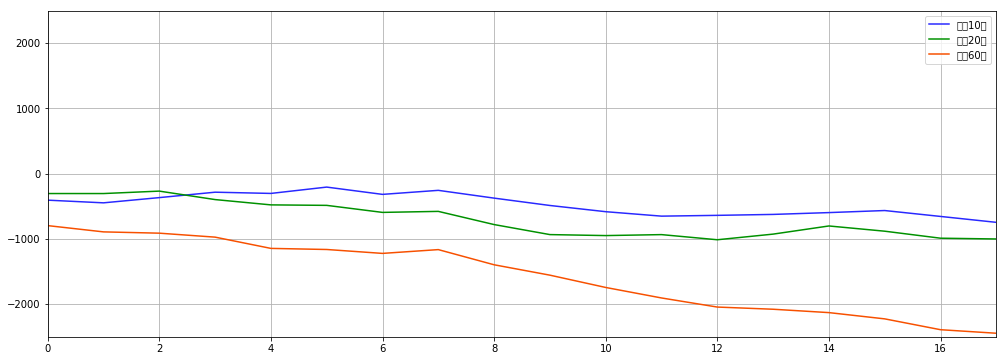

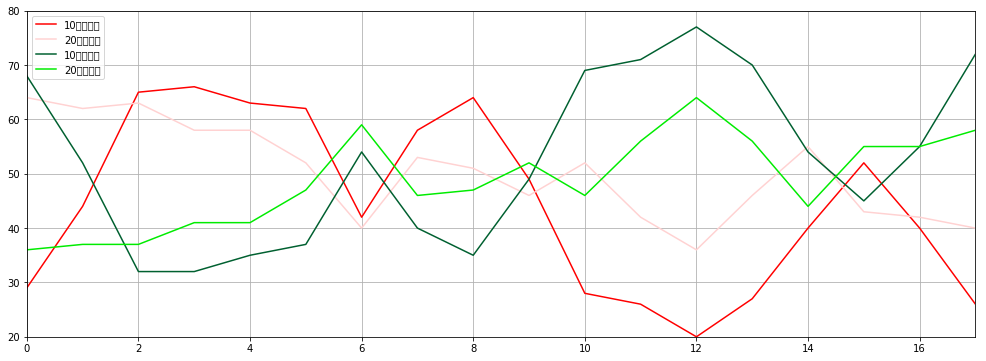

In [9]:
%pylab inline
from colorama import Fore
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sheetName = 'tw100' # 台灣100
df = pd.read_excel('files/data.xlsx', sheetname=sheetName)
# 外資買賣超
df1 = df[['外資10日','外資20日','外資60日']]
df1.plot(ylim=(-2500,2500),linestyle='-',kind='line',figsize=(17,6),color=['#2828FF','#009100','#F75000'],grid=True) 
# TW100趨勢
df2 = df[['10日線向上','20日線向上','10日線向下','20日線向下']]
df2.plot(ylim=(20,80),linestyle='-',kind='line',figsize=(17,6),color=['#ff0000','#ffd2d2','#006030','#00ec00'],grid=True) 

# 盤勢分析
# 1. 趨勢：開盤收盤超過40點 => 趨勢盤
# 2. 波動：計算過去8天最高和最低差 (波動越小, 就越困難操作)
df['漲跌差'] = df['CLOSE'] - df['OPEN']
conditions = [
    (df['OPEN'] - df['CLOSE'] > 40),
    (df['OPEN'] - df['CLOSE'] < -40)]
choices = ['順', '順']
df['盤勢'] = np.select(conditions, choices, default='-')
df['波動'] = df['HIGH8D'] - df['LOW8D']
df['趨勢分析'] = np.where(df['波動'] < 180, '盤', '-')

# 大盤多空分析：
# 1. 大盤月線 + 大盤DIF(先不考慮季線)
# 1.1. 月上DIF上 => 多; 
# 1.2. 月上DIF下 => 盤;
# 1.3. 月下DIF上 => 盤;
# 1.4. 月下DIF下 => 空;
conditions = [
    (df['月線方向'] + df['DIF方向'] == 2),
    (df['月線方向'] + df['DIF方向'] == -2)]
choices = ['多', '空']
df['大盤多空'] = np.select(conditions, choices, default='-')

# 2. 外資籌碼
# 2.1. 10日正20日正 => 多
# 2.2. 10日正20日負 => 盤
# 2.3. 10日負20日正 => 盤
# 2.4. 10日負20日負 => 空
conditions = [
    (df['外資10日'] + df['外資20日'] > 300),
    (df['外資10日'] + df['外資20日'] < -300)]
choices = ['多', '空']
df['外資籌碼'] = np.select(conditions, choices, default='-')

# 3. 個股K線
# 3.1. TW100差 大於  25  => 多
# 3.2. TW100差 小於 -25  => 空
# 3.3. TW100差 介於 之間 => 盤 
df['TW100差'] = df['10日線向上'] - df['10日線向下']
conditions = [
    (df['10日線向上'] - df['10日線向下'] > 25),
    (df['10日線向上'] - df['10日線向下'] < -25)]
choices = ['多', '空']
df['個股K線'] = np.select(conditions, choices, default='-')

print(Fore.RED+'波動度太差, 會非常不利長線出手！！！ 低於180長線建議減碼！')
df[['漲跌差','盤勢','波動','趨勢分析','月線方向','DIF方向','大盤多空','外資10日','外資20日','外資60日','外資籌碼','10日線向上','10日線向下','TW100差','個股K線']].tail(10)


## 個股-交易統計記錄

In [10]:
import pandas as pd
import numpy as np
from colorama import Fore

sheetName = 'stock'

df = pd.read_excel('files/data.xlsx', sheetname=sheetName)

df

,交易日期,個股標的,成交價,初始停損價,停損價,出場日期,損益
0,2018-04-25,微星期,89.6,85.9,92.82,NaN,NaN


## 期貨-每月期望值統計資料

In [11]:
import pandas as pd
import numpy as np
from colorama import Fore

sheetName = 'all' # 交易資料 by 年份

dates=['2018-12','2018-11','2018-10','2018-9','2018-8','2018-7',\
       '2018-6','2018-5','2018-4','2018-3','2018-2','2018-1', \
       '2017-12','2017-11','2017-10']

#dates=['2017-12','2017-11','2017-10']

df = pd.read_excel('files/data.xlsx', sheetname=sheetName)

df['Date'] = df['成交時間'].dt.year.astype(str)+'-'+df['成交時間'].dt.month.astype(str)
df['Lot'] = df['口數']
df['Balance'] = df['平倉損益']

df = df[['Date','Lot','Balance']]

datas = []
for date in reversed(dates):
    df1 = df[df['Date']==date]
    if not df1.empty:
        obj = {}
        obj['年月份'] = date
        obj['虧損口數'] = df1[df1['Balance']<0]['Lot'].sum()
        obj['獲利口數'] = df1[df1['Balance']>=0]['Lot'].sum()
        obj['總口數'] = df1['Lot'].sum()
        obj['勝率%'] = str(round((obj['獲利口數'] / obj['總口數'])*100, 1))+'%'
        obj['總虧損'] = df1[df1['Balance']<0]['Balance'].sum()
        obj['總獲利'] = df1[df1['Balance']>=0]['Balance'].sum()
        obj['淨利'] = df1['Balance'].sum()
        obj['期望報酬'] = round((obj['淨利'] / obj['總口數']))
        obj['平均虧損'] = round(obj['總虧損'] / obj['虧損口數'],0)
        obj['平均獲利'] = round(obj['總獲利'] / obj['獲利口數'],0)
        obj['盈虧比'] = str(round((obj['平均獲利'] / obj['平均虧損'] * -1),2))+':1'
        obj['最大虧損'] = df1['Balance'].min()
        obj['最大獲利'] = df1['Balance'].max()
        obj['交易品質A'] = round((obj['平均獲利'] / obj['平均虧損'] * -1) - (obj['虧損口數'] / obj['獲利口數']),2)
        obj['交易品質B'] = str(round(100*((obj['獲利口數'] / obj['總口數']) * (obj['平均獲利'] / obj['平均虧損'] * -1) - (1 - (obj['獲利口數'] / obj['總口數']))),1))+'%'
        datas.append(obj)

# Total        
obj ={}
obj['年月份'] = 'Total'
obj['虧損口數'] = df[df['Balance']<0]['Lot'].sum()
obj['獲利口數'] = df[df['Balance']>=0]['Lot'].sum()
obj['總口數'] = df['Lot'].sum()
obj['勝率%'] = str(round((obj['獲利口數'] / obj['總口數'])*100, 1))+'%'
obj['總虧損'] = df[df['Balance']<0]['Balance'].sum()
obj['總獲利'] = df[df['Balance']>=0]['Balance'].sum()
obj['淨利'] = df['Balance'].sum()
obj['期望報酬'] = round((obj['淨利'] / obj['總口數']))
obj['平均虧損'] = round(obj['總虧損'] / obj['虧損口數'],0)
obj['平均獲利'] = round(obj['總獲利'] / obj['獲利口數'],0)
obj['盈虧比'] = str(round((obj['平均獲利'] / obj['平均虧損'] * -1),2))+':1'
obj['最大虧損'] = df['Balance'].min()
obj['最大獲利'] = df['Balance'].max()
obj['交易品質A'] = round((obj['平均獲利'] / obj['平均虧損'] * -1) - (obj['虧損口數'] / obj['獲利口數']),2)
obj['交易品質B'] = str(round(100*((obj['獲利口數'] / obj['總口數']) * (obj['平均獲利'] / obj['平均虧損'] * -1) - (1 - (obj['獲利口數'] / obj['總口數']))),1))+'%'
datas.insert(0,obj)
       
df = pd.DataFrame(datas).sort_index(ascending=False)

print(Fore.RED+'交易聖經：接受最大逆境; 市場該做的事就是讓大多數的人失望！永遠不要覺得好像容易了...')

df[['年月份','虧損口數','獲利口數','總口數','勝率%','總虧損','總獲利','淨利','期望報酬','平均虧損','平均獲利','盈虧比','最大虧損','最大獲利','交易品質A','交易品質B']]

# 交易系統關鍵：正期望值 * 交易機會 * 部位大小(破產風險)
# 交易品質A：大於1表示完美; 0.75~1表示不錯; 0.5~0.75表示可用稍不足; 小於0.5表示不能用
# 交易品質B：勝率50%+盈虧比3:1表示100%期望值(完美); 勝率50%+盈虧比2:1表示50%期望值; 品質至少要維持33%以上

交易聖經：接受最大逆境; 市場該做的事就是讓大多數的人失望！永遠不要覺得好像容易了...


,年月份,虧損口數,獲利口數,總口數,勝率%,總虧損,總獲利,淨利,期望報酬,平均虧損,平均獲利,盈虧比,最大虧損,最大獲利,交易品質A,交易品質B
8,2018-5,6,6,12,50.0%,-5336,9320,3984,332.0,-889.0,1553.0,1.75:1,-3108,7336,0.75,37.3%
7,2018-4,55,20,75,26.7%,-100918,86312,-14606,-195.0,-1835.0,4316.0,2.35:1,-18000,30936,-0.40,-10.6%
6,2018-3,74,64,138,46.4%,-87646,123864,36218,262.0,-1184.0,1935.0,1.63:1,-10896,23092,0.48,22.2%
5,2018-2,22,20,42,47.6%,-33177,74996,41819,996.0,-1508.0,3750.0,2.49:1,-7314,17940,1.39,66.0%
4,2018-1,11,14,25,56.0%,-8024,35080,27056,1082.0,-729.0,2506.0,3.44:1,-3264,11218,2.65,148.5%
3,2017-12,9,11,20,55.0%,-14128,13961,-167,-8.0,-1570.0,1269.0,0.81:1,-4481,7019,-0.01,-0.5%
2,2017-11,7,3,10,30.0%,-8674,7104,-1570,-157.0,-1239.0,2368.0,1.91:1,-3132,5968,-0.42,-12.7%
1,2017-10,6,9,15,60.0%,-8090,17965,9875,658.0,-1348.0,1996.0,1.48:1,-2032,14069,0.81,48.8%
0,Total,190,147,337,43.6%,-265993,368602,102609,304.0,-1400.0,2507.0,1.79:1,-18000,30936,0.50,21.7%


## 部位規模控制 - 固定百分率
#### 固定百分率 - 專業交易員最常用
#### 公式：合約口數 = (固定百分率 * 帳戶餘額) / 個別交易風險
#### 個別交易風險: 近三個月平均虧損的平均

In [12]:
positionSize = 0
固定百分率 = 0.03 # 帳戶規模越大要降低風險最佳1-2%
帳戶餘額 = obj['淨利']
for i in range(5,0,-1):
    個別交易風險 = abs((datas[-1]['平均虧損'] + datas[-2]['平均虧損'] + datas[-3]['平均虧損']) / 3) * i
    if(positionSize == 0 and round((固定百分率 * 帳戶餘額) / 個別交易風險,2) > 1):
        positionSize = i
    print('Lot:',i, '部位門檻:',round((固定百分率 * 帳戶餘額) / 個別交易風險,2))
    
print('計算可交易部位：',positionSize)

Lot: 5 部位門檻: 0.47
Lot: 4 部位門檻: 0.59
Lot: 3 部位門檻: 0.79
Lot: 2 部位門檻: 1.18
Lot: 1 部位門檻: 2.36
計算可交易部位： 2


## 破產風險 ＆ 期望報酬(R)
#### 破產風險 = 虧損機率 ** ( ( 淨利  x  0.1 ) / ( 平均虧損 x 部位規模 ) ) ---- 破產定義：淨利減少1成就算破產!! XD
#### 單筆虧損(%) 建議要低於 2%, 1.5%更佳; 長期甚至低於1%
#### 破產風險(%) 建議要降為 0%

In [13]:
print('部位規模    : '+str(positionSize))  # 部位規模
print('目前淨利    : '+str(obj['淨利']))
print('單筆虧損(%) : '+str(round(abs((obj['平均虧損'] * positionSize) / obj['淨利']),3) * 100)+'%')
print('平均虧損    : '+str(round(obj['總虧損'] / obj['虧損口數'],0)))
print('破產風險    : '+str(round((obj['虧損口數'] / obj['總口數']) ** abs((obj['淨利']*0.1) / (obj['平均虧損'] * (positionSize))) * 100, 2))+'%')
print('期望報酬(R) : '+str(round((obj['期望報酬'] / obj['平均虧損']) * -1,2))+'R')
print('實現報酬(R) : '+str(round((obj['期望報酬'] / obj['平均虧損']) * -1,2) * obj['總口數'] )+'R')
print('=========================')
print('淨利七成    : '+str(round((obj['虧損口數'] / obj['總口數']) ** abs((obj['淨利']*0.3) / (obj['平均虧損'] * (positionSize))) * 100, 2))+'%')
print('淨利減半    : '+str(round((obj['虧損口數'] / obj['總口數']) ** abs((obj['淨利']*0.5) / (obj['平均虧損'] * (positionSize))) * 100, 2))+'%')

部位規模    : 2
目前淨利    : 102609
單筆虧損(%) : 2.7%
平均虧損    : -1400.0
破產風險    : 12.25%
期望報酬(R) : 0.22R
實現報酬(R) : 74.14R
淨利七成    : 0.18%
淨利減半    : 0.0%


## 每月交易統計紀錄

In [14]:
import pandas as pd
import numpy as np



df = pd.read_excel('files/data.xlsx', sheetname=sheetName)

df['Date'] = df['成交時間'].dt.year.astype(str)+'-'+df['成交時間'].dt.month.astype(str)
df['Lot'] = df['口數']
df['Balance'] = df['平倉損益']

df = df[['Date','Lot','Balance']]

datas = []
for date in reversed(dates):
    df1 = df[df['Date']==date]
    if not df1.empty:
        obj = {}
        obj['年月份'] = date
        obj['-120~90'] = df1[(df1['Balance']/df1['Lot'] >= -6000) & (df1['Balance']/df1['Lot'] < -4500)]['Lot'].sum()
        obj['-90~60'] = df1[(df1['Balance']/df1['Lot'] >= -4500) & (df1['Balance']/df1['Lot'] < -3000)]['Lot'].sum()
        obj['-60~45'] = df1[(df1['Balance']/df1['Lot'] >= -3000) & (df1['Balance']/df1['Lot'] < -2250)]['Lot'].sum()
        obj['-45~30'] = df1[(df1['Balance']/df1['Lot'] >= -2250) & (df1['Balance']/df1['Lot'] < -1500)]['Lot'].sum()
        obj['-30~15'] = df1[(df1['Balance']/df1['Lot'] >= -1500) & (df1['Balance']/df1['Lot'] < -750)]['Lot'].sum()
        obj['-15~0'] = df1[(df1['Balance']/df1['Lot'] >= -750) & (df1['Balance']/df1['Lot'] < 0)]['Lot'].sum()
        obj['0~15'] = df1[(df1['Balance']/df1['Lot'] >= 0) & (df1['Balance']/df1['Lot'] < 750)]['Lot'].sum()
        obj['15~30'] = df1[(df1['Balance']/df1['Lot'] >= 750) & (df1['Balance']/df1['Lot'] < 1500)]['Lot'].sum()
        obj['30~45'] = df1[(df1['Balance']/df1['Lot'] >= 1500) & (df1['Balance']/df1['Lot'] < 2250)]['Lot'].sum()
        obj['45~60'] = df1[(df1['Balance']/df1['Lot'] >= 2250) & (df1['Balance']/df1['Lot'] < 3000)]['Lot'].sum()
        obj['60~90'] = df1[(df1['Balance']/df1['Lot'] >= 3000) & (df1['Balance']/df1['Lot'] < 4500)]['Lot'].sum()
        obj['90~120'] = df1[(df1['Balance']/df1['Lot'] >= 4500) & (df1['Balance']/df1['Lot'] < 6000)]['Lot'].sum()
        obj['120~150'] = df1[(df1['Balance']/df1['Lot'] >= 6000) & (df1['Balance']/df1['Lot'] < 7500)]['Lot'].sum()
        obj['150~180'] = df1[(df1['Balance']/df1['Lot'] >= 7500) & (df1['Balance']/df1['Lot'] < 9000)]['Lot'].sum()
        obj['180~210'] = df1[(df1['Balance']/df1['Lot'] >= 9000) & (df1['Balance']/df1['Lot'] < 10500)]['Lot'].sum()
        obj['210~240'] = df1[(df1['Balance']/df1['Lot'] >= 10500) & (df1['Balance']/df1['Lot'] < 12000)]['Lot'].sum()
        obj['240~500'] = df1[(df1['Balance']/df1['Lot'] >= 12000) & (df1['Balance']/df1['Lot'] < 25000)]['Lot'].sum()
        datas.append(obj)

# Lot Sum
obj = {}
obj['年月份'] = 'Total'
obj['-120~90'] = df[(df['Balance']/df['Lot'] >= -6000) & (df['Balance']/df['Lot'] < -4500)]['Lot'].sum()
obj['-90~60'] = df[(df['Balance']/df['Lot'] >= -4500) & (df['Balance']/df['Lot'] < -3000)]['Lot'].sum()
obj['-60~45'] = df[(df['Balance']/df['Lot'] >= -3000) & (df['Balance']/df['Lot'] < -2250)]['Lot'].sum()
obj['-45~30'] = df[(df['Balance']/df['Lot'] >= -2250) & (df['Balance']/df['Lot'] < -1500)]['Lot'].sum()
obj['-30~15'] = df[(df['Balance']/df['Lot'] >= -1500) & (df['Balance']/df['Lot'] < -750)]['Lot'].sum()
obj['-15~0'] = df[(df['Balance']/df['Lot'] >= -750) & (df['Balance']/df['Lot'] < 0)]['Lot'].sum()
obj['0~15'] = df[(df['Balance']/df['Lot'] >= 0) & (df['Balance']/df['Lot'] < 750)]['Lot'].sum()
obj['15~30'] = df[(df['Balance']/df['Lot'] >= 750) & (df['Balance']/df['Lot'] < 1500)]['Lot'].sum()
obj['30~45'] = df[(df['Balance']/df['Lot'] >= 1500) & (df['Balance']/df['Lot'] < 2250)]['Lot'].sum()
obj['45~60'] = df[(df['Balance']/df['Lot'] >= 2250) & (df['Balance']/df['Lot'] < 3000)]['Lot'].sum()
obj['60~90'] = df[(df['Balance']/df['Lot'] >= 3000) & (df['Balance']/df['Lot'] < 4500)]['Lot'].sum()
obj['90~120'] = df[(df['Balance']/df['Lot'] >= 4500) & (df['Balance']/df['Lot'] < 6000)]['Lot'].sum()
obj['120~150'] = df[(df['Balance']/df['Lot'] >= 6000) & (df['Balance']/df['Lot'] < 7500)]['Lot'].sum()
obj['150~180'] = df[(df['Balance']/df['Lot'] >= 7500) & (df['Balance']/df['Lot'] < 9000)]['Lot'].sum()
obj['180~210'] = df[(df['Balance']/df['Lot'] >= 9000) & (df['Balance']/df['Lot'] < 10500)]['Lot'].sum()
obj['210~240'] = df[(df['Balance']/df['Lot'] >= 10500) & (df['Balance']/df['Lot'] < 12000)]['Lot'].sum()
obj['240~500'] = df[(df['Balance']/df['Lot'] >= 12000) & (df['Balance']/df['Lot'] < 25000)]['Lot'].sum()
datas.insert(0,obj)

# Balance Sum
obj = {}
obj['年月份'] = '損益金額'
obj['-120~90'] = df[(df['Balance']/df['Lot'] >= -6000) & (df['Balance']/df['Lot'] < -4500)]['Balance'].sum()
obj['-90~60'] = df[(df['Balance']/df['Lot'] >= -4500) & (df['Balance']/df['Lot'] < -3000)]['Balance'].sum()
obj['-60~45'] = df[(df['Balance']/df['Lot'] >= -3000) & (df['Balance']/df['Lot'] < -2250)]['Balance'].sum()
obj['-45~30'] = df[(df['Balance']/df['Lot'] >= -2250) & (df['Balance']/df['Lot'] < -1500)]['Balance'].sum()
obj['-30~15'] = df[(df['Balance']/df['Lot'] >= -1500) & (df['Balance']/df['Lot'] < -750)]['Balance'].sum()
obj['-15~0'] = df[(df['Balance']/df['Lot'] >= -750) & (df['Balance']/df['Lot'] < 0)]['Balance'].sum()
obj['0~15'] = df[(df['Balance']/df['Lot'] >= 0) & (df['Balance']/df['Lot'] < 750)]['Balance'].sum()
obj['15~30'] = df[(df['Balance']/df['Lot'] >= 750) & (df['Balance']/df['Lot'] < 1500)]['Balance'].sum()
obj['30~45'] = df[(df['Balance']/df['Lot'] >= 1500) & (df['Balance']/df['Lot'] < 2250)]['Balance'].sum()
obj['45~60'] = df[(df['Balance']/df['Lot'] >= 2250) & (df['Balance']/df['Lot'] < 3000)]['Balance'].sum()
obj['60~90'] = df[(df['Balance']/df['Lot'] >= 3000) & (df['Balance']/df['Lot'] < 4500)]['Balance'].sum()
obj['90~120'] = df[(df['Balance']/df['Lot'] >= 4500) & (df['Balance']/df['Lot'] < 6000)]['Balance'].sum()
obj['120~150'] = df[(df['Balance']/df['Lot'] >= 6000) & (df['Balance']/df['Lot'] < 7500)]['Balance'].sum()
obj['150~180'] = df[(df['Balance']/df['Lot'] >= 7500) & (df['Balance']/df['Lot'] < 9000)]['Balance'].sum()
obj['180~210'] = df[(df['Balance']/df['Lot'] >= 9000) & (df['Balance']/df['Lot'] < 10500)]['Balance'].sum()
obj['210~240'] = df[(df['Balance']/df['Lot'] >= 10500) & (df['Balance']/df['Lot'] < 12000)]['Balance'].sum()
obj['240~500'] = df[(df['Balance']/df['Lot'] >= 12000) & (df['Balance']/df['Lot'] < 25000)]['Balance'].sum()
datas.insert(0,obj)

        
df = pd.DataFrame(datas).sort_index(ascending=False)
df = df[['年月份','-120~90','-90~60','-60~45','-45~30','-30~15','-15~0','0~15','15~30','30~45','45~60','60~90', \
         '90~120','120~150','150~180','180~210','210~240','240~500']]

df

,年月份,-120~90,-90~60,-60~45,-45~30,-30~15,-15~0,0~15,15~30,30~45,45~60,60~90,90~120,120~150,150~180,180~210,210~240,240~500
9,2018-5,0,0,0,2,0,4,4,0,0,0,2,0,0,0,0,0,0
8,2018-4,6,3,6,8,14,18,11,0,0,0,3,0,0,0,2,2,2
7,2018-3,4,3,5,7,17,38,30,11,8,5,3,2,0,2,0,3,0
6,2018-2,0,4,0,4,9,5,7,2,1,2,0,2,1,4,1,0,0
5,2018-1,0,0,0,2,2,7,7,2,0,1,2,0,0,0,1,1,0
4,2017-12,0,1,0,3,2,3,9,0,0,0,1,0,1,0,0,0,0
3,2017-11,0,1,0,2,0,4,2,0,0,0,0,1,0,0,0,0,0
2,2017-10,0,0,0,4,0,2,5,3,0,0,0,0,0,0,0,0,1
1,Total,10,12,11,32,44,81,75,18,9,8,11,5,2,6,4,6,3
0,損益金額,-51824,-44733,-31302,-57242,-46504,-34388,21646,19236,17148,21000,40084,28746,14117,52716,39306,69598,45005


## 交易紀錄統計長條圖

Populating the interactive namespace from numpy and matplotlib


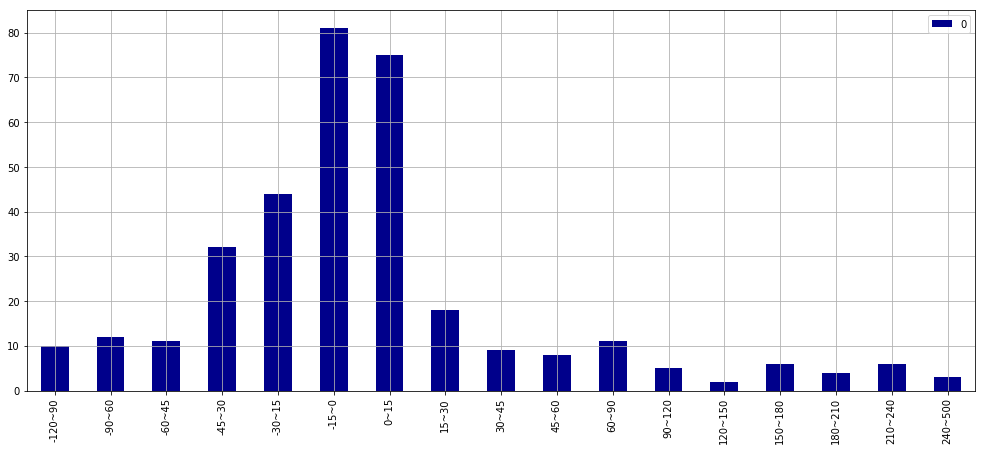

In [15]:
%pylab inline

import pandas as pd
import numpy as np

df = pd.read_excel('files/data.xlsx', sheetname=sheetName)

df['Date'] = df['成交時間'].dt.year.astype(str)+df['成交時間'].dt.month.astype(str)
df['Lot'] = df['口數']
df['Balance'] = df['平倉損益']

df = df[['Date','Lot','Balance']]

obj = {}
obj['-120~90'] = df[(df['Balance']/df['Lot'] >= -6000) & (df['Balance']/df['Lot'] < -4500)]['Lot'].sum()
obj['-90~60'] = df[(df['Balance']/df['Lot'] >= -4500) & (df['Balance']/df['Lot'] < -3000)]['Lot'].sum()
obj['-60~45'] = df[(df['Balance']/df['Lot'] >= -3000) & (df['Balance']/df['Lot'] < -2250)]['Lot'].sum()
obj['-45~30'] = df[(df['Balance']/df['Lot'] >= -2250) & (df['Balance']/df['Lot'] < -1500)]['Lot'].sum()
obj['-30~15'] = df[(df['Balance']/df['Lot'] >= -1500) & (df['Balance']/df['Lot'] < -750)]['Lot'].sum()
obj['-15~0'] = df[(df['Balance']/df['Lot'] >= -750) & (df['Balance']/df['Lot'] < 0)]['Lot'].sum()
obj['0~15'] = df[(df['Balance']/df['Lot'] >= 0) & (df['Balance']/df['Lot'] < 750)]['Lot'].sum()
obj['15~30'] = df[(df['Balance']/df['Lot'] >= 750) & (df['Balance']/df['Lot'] < 1500)]['Lot'].sum()
obj['30~45'] = df[(df['Balance']/df['Lot'] >= 1500) & (df['Balance']/df['Lot'] < 2250)]['Lot'].sum()
obj['45~60'] = df[(df['Balance']/df['Lot'] >= 2250) & (df['Balance']/df['Lot'] < 3000)]['Lot'].sum()
obj['60~90'] = df[(df['Balance']/df['Lot'] >= 3000) & (df['Balance']/df['Lot'] < 4500)]['Lot'].sum()
obj['90~120'] = df[(df['Balance']/df['Lot'] >= 4500) & (df['Balance']/df['Lot'] < 6000)]['Lot'].sum()
obj['120~150'] = df[(df['Balance']/df['Lot'] >= 6000) & (df['Balance']/df['Lot'] < 7500)]['Lot'].sum()
obj['150~180'] = df[(df['Balance']/df['Lot'] >= 7500) & (df['Balance']/df['Lot'] < 9000)]['Lot'].sum()
obj['180~210'] = df[(df['Balance']/df['Lot'] >= 9000) & (df['Balance']/df['Lot'] < 10500)]['Lot'].sum()
obj['210~240'] = df[(df['Balance']/df['Lot'] >= 10500) & (df['Balance']/df['Lot'] < 12000)]['Lot'].sum()
obj['240~500'] = df[(df['Balance']/df['Lot'] >= 12000) & (df['Balance']/df['Lot'] < 25000)]['Lot'].sum()

df = pd.DataFrame(obj, index=[0])
df = df[['-120~90','-90~60','-60~45','-45~30','-30~15','-15~0','0~15','15~30','30~45','45~60', \
         '60~90','90~120','120~150','150~180','180~210','210~240','240~500']]

df = pd.DataFrame(df.stack()[0])
df.plot(kind='bar',figsize=(17,7),color='DarkBlue',grid=True) # DarkGreen, DarkOrange, DarkBlue, Gray

## 平倉損益淨利累積曲線圖

Populating the interactive namespace from numpy and matplotlib


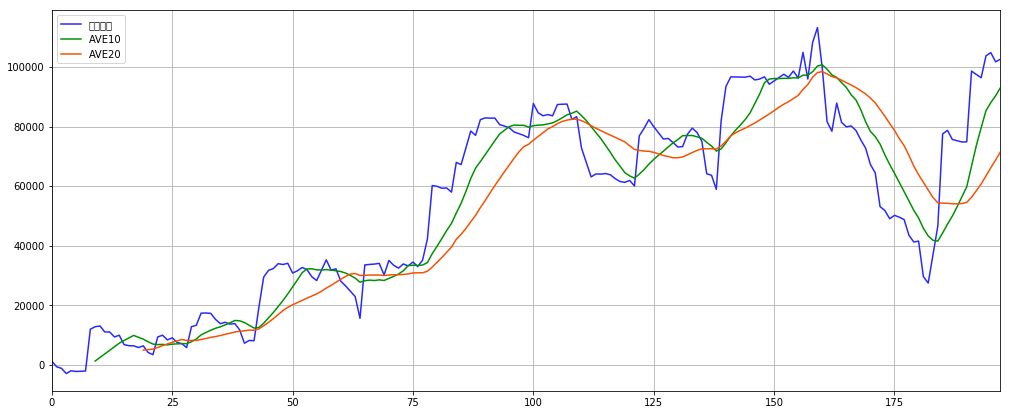

In [16]:
%pylab inline

import pandas as pd
import numpy as np

df = pd.read_excel('files/data.xlsx', sheetname=sheetName)
df = pd.DataFrame(df['平倉損益'].cumsum())

df['AVE10'] =  df['平倉損益'].rolling(window = 10).mean()
df['AVE20'] =  df['平倉損益'].rolling(window = 20).mean()
df
df.plot(linestyle='-',kind='line',figsize=(17,7),color=['#2828FF','#009100','#F75000'],grid=True) 

# End!!